<a href="https://colab.research.google.com/github/simionattovini/Hoisting-and-Rigging-Machinery/blob/main/Pendulum%20Load%20Traversing/MET_Sistema_com_Carga_Pendular_4_Simula%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema com Carga Pendular - Simulação

## Simulação

A princípio, precisamos entrar com os dados do sistema. Tais dados se encontram a seguir. A função ```f(t)``` deve representar a força aplicada no sistema (no caso, o carrinho) em um instante $t$.

In [102]:
# Dados do sistema:

M = 200   # kg
m = 10    # kg
L = 10    # m
Ig = 3    # kg.m²
g = 9.81  # m/s²

# Dados do cabo ou controlador:

kc = 1500000
cc = 460*0
ct = 3350*0

# Dados da curva de controle

s = 20     # m    -> Espaço a se deslocar
vm = 3     # m/s  -> Velocidade média máxima
tacc = 30  # s    -> Tempo para acelerar de 0 à velocidade média máxima

# Dados da simulação:

Tf = 45    # s    -> Tempo final

# Dados da animação

trwid = 1.5    # Largura do carrinho [m]
trhei = 0.7    # Altura do carrinho [m]
whdiam = 0.3   # Diâmetro das rodas [m]
fscale = 0.04  # Escala do vetor de força [-]

xlim = [-2, 25]  # Limites em x do frame da animação
ylim = [-12, 2]   # Limites em y do frame da animação


Abaixo definimos a função set-point.

In [103]:
import numpy as np

# Função set-point

def set_point(t, s, vm, tacc):

  if t<0:
    return 0

  if s/vm < tacc:
    a = vm/tacc
    tacc = np.sqrt(s/a)

    if 0<=t<tacc:
      Y = a*(t**2)/2
    elif tacc<t<2*tacc:
      Y = a*tacc**2/2 + a*tacc*(t-tacc)- a*((t-tacc)**2)/2
    else:
      Y = s

  else:
    ts = s/vm-tacc
    tf = 2*tacc+ts

    if 0<=t<tacc:
      Y = (vm/tacc)*(t**2)/2
    elif tacc<t<(tacc+ts):
      Y = vm*tacc/2 + vm*(t-tacc)
    elif (tacc+ts)<t<tf:
      Y = vm*tacc/2 + vm*ts + vm*(t-(ts+tacc)) - (vm/tacc)*((t-(ts+tacc))**2)/2
    else:
      Y = s

  return Y

# Deslocamento virtual de entrada
fun_y = lambda t: set_point(t, s, vm, tacc)

# Aproximação da derivada da função set-point
def fun_dy(t, dt=1e-6):
  if t <= 0:
    return 0
  return (fun_y(t+dt) - fun_y(t-dt))/(2*dt)

E então plotamos a função e sua derivada.

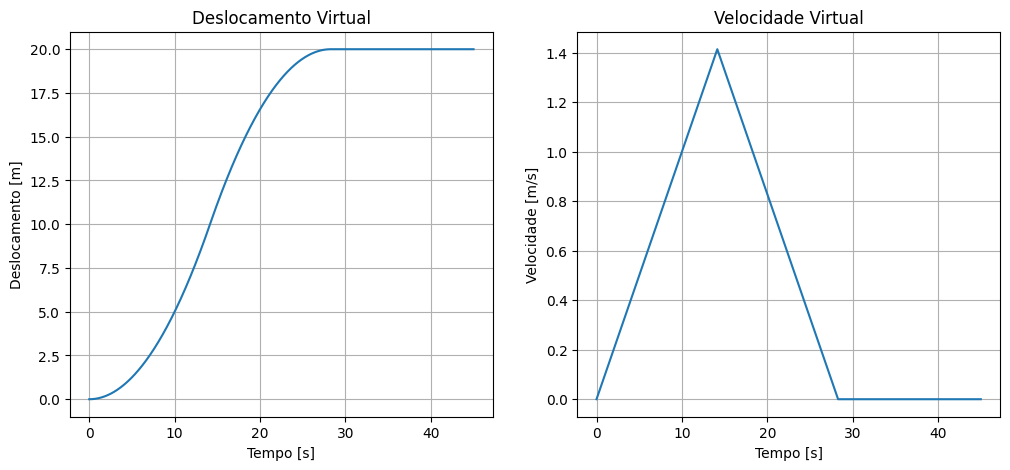

In [104]:
import matplotlib.pyplot as plt

t_plot = np.linspace(0, Tf, 1000)
Y = np.asarray(list(map(fun_y, t_plot)))
dY = np.asarray(list(map(fun_dy, t_plot)))

plt.figure(figsize = (12,5))

plt.subplot(1,2,1)
plt.plot(t_plot, Y)
plt.xlabel('Tempo [s]')
plt.ylabel('Deslocamento [m]')
plt.title('Deslocamento Virtual')
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(t_plot, dY)
plt.xlabel('Tempo [s]')
plt.ylabel('Velocidade [m/s]')
plt.title('Velocidade Virtual')
plt.grid(True)

plt.show()

Devemos então realizar a simulação, e para isso devemos montar as matrizes do sistema e da forma de estados conforme visto anteriormente:

In [105]:
# Matrizes do sistema em malha fechada:

MI = np.asarray([[Ig+M*L**2, M*L], [M*L, M+m]])
MC = np.asarray([[0, 0], [ct, cc]])
MK = np.asarray([[M*g*L, 0], [0, kc]])

A = np.append(np.append(np.zeros((2, 2)),
                        np.eye(2), 1),
              np.append(-np.linalg.inv(MI) @ MK,
                        -np.linalg.inv(MI) @ MC, 1),
              0)

B = np.append(np.zeros((2, 1)), np.linalg.inv(MI) @ np.asarray([[0], [1]]), 0)

C = np.asarray([[0, 1, 0, 0]])

D = np.asarray([[0]])

Com as matrizes montadas, precisamos agora criar uma função ```sysfun(t, y, ...)``` que represente as equações de movimento do sistema na forma de estados. Utilizaremos esta função para realizar uma integração numérica utilizando a função ```solve_ivp``` do Scipy.

In [106]:
# Integração Numérica

from scipy.integrate import solve_ivp

# Parâmetros de integração

t_span = [0, Tf]
Npts = t_span[1]*30  # 30 = 30fps
T = np.linspace(t_span[0], t_span[1], Npts)

def sysfun(t, y, A, B, kc, cc):
    return A @ y + B.flatten() * (kc*fun_y(t) + cc*fun_dy(t))

y0 = np.zeros((4, ))

sol = solve_ivp(lambda t, y: sysfun(t, y, A, B, kc, cc), t_span, y0, t_eval=T)

print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  3.336e-02 ...  4.497e+01  4.500e+01]
        y: [[ 0.000e+00 -5.563e-06 ... -1.124e-02 -1.167e-02]
            [ 0.000e+00  5.564e-05 ...  2.000e+01  2.000e+01]
            [ 0.000e+00 -3.220e-04 ...  1.184e-02  2.381e-02]
            [ 0.000e+00  3.221e-03 ... -2.547e-01 -3.707e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 123242
     njev: 0
      nlu: 0


Deste ponto em diante está o código para criar a animação com os dados da simulação.

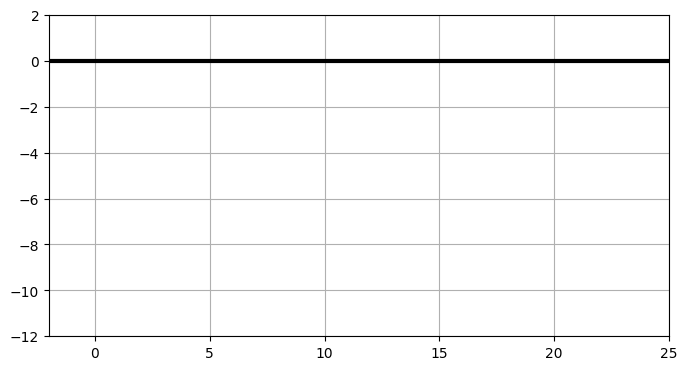

In [107]:
# Animação

import matplotlib.pyplot as plt
from matplotlib import animation

fig = plt.figure(figsize=(8, 6))

ax = plt.gca()
ax.set_aspect('equal')
ax.set_xlim(xlim[0], xlim[1])
ax.set_ylim(ylim[0], ylim[1])
ax.plot(xlim, [0, 0], 'k', linewidth=3)
ax.grid(True)
trolley_body, = ax.plot([], [], 'b', linewidth=2)
trolley_wheel_1, = ax.plot([], [], 'k', linewidth=2)
trolley_wheel_2, = ax.plot([], [], 'k', linewidth=2)
pendulum_rod, = ax.plot([], [], color=[0.4, 0.4, 0.4], linewidth=1.5)
pendulum_bob, = ax.plot([], [], 'ko', markersize=100, markerfacecolor='k')
force_arrow, = ax.plot([], [], 'r', linewidth=1.5)


In [108]:
nframes = Npts;

def circlepts(x, y, r, n=10):
  th = np.linspace(0, 2*np.pi, n+1)
  return x+r*np.cos(th), y+r*np.sin(th)

def update_trolley(x,
                   trolley_body,
                   trolley_wheel_1,
                   trolley_wheel_2,
                   wid, hei, diam):
  trolley_body.set_data([x-wid/2, x+wid/2, x+wid/2, x-wid/2, x-wid/2],
                        [diam, diam, diam+hei, diam+hei, diam])
  wh = circlepts(x-wid/2+diam, diam/2, diam/2)
  trolley_wheel_1.set_data(wh[0], wh[1])
  wh = circlepts(x+wid/2-diam, diam/2, diam/2)
  trolley_wheel_2.set_data(wh[0], wh[1])

def update_pendulum(x, th,
                    pendulum_rod,
                    pendulum_bob,
                    wid, hei, diam, L):
  pendulum_rod.set_data([x, x+L*np.sin(th)],
                        [diam+hei/2, diam+hei/2-L*np.cos(th)])
  pendulum_bob.set_data([x+L*np.sin(th)],
                        [diam+hei/2-L*np.cos(th)])

def update_force_arrow(x, force, scale, force_arrow, wid, hei, diam):
  f_len = np.abs(force*scale)
  f_tip = min(f_len, diam/2)
  if force>0:
    force_arrow.set_data([x+wid/2,
                          x+wid/2+f_len,
                          x+wid/2+f_len-f_tip,
                          x+wid/2+f_len,
                          x+wid/2+f_len-f_tip,
                          x+wid/2+f_len],
                         [diam+hei/2,
                          diam+hei/2,
                          diam+hei/2+f_tip,
                          diam+hei/2,
                          diam+hei/2-f_tip,
                          diam+hei/2])
  elif force<0:
    force_arrow.set_data([x-wid/2,
                          x-wid/2-f_len,
                          x-wid/2-f_len+f_tip,
                          x-wid/2-f_len,
                          x-wid/2-f_len+f_tip,
                          x-wid/2-f_len],
                         [diam+hei/2,
                          diam+hei/2,
                          diam+hei/2+f_tip,
                          diam+hei/2,
                          diam+hei/2-f_tip,
                          diam+hei/2])
  else:
    force_arrow.set_data([0],[0])


def mydrawframe(n,
                trolley_body,
                trolley_wheel_1,
                trolley_wheel_2,
                pendulum_rod,
                pendulum_bob,
                force_arrow,
                wid,
                hei,
                diam,
                L,
                scale,
                xdata,
                thdata,
                fdata):


  update_trolley(xdata[n],
                 trolley_body,
                 trolley_wheel_1,
                 trolley_wheel_2,
                 wid, hei, diam)

  update_pendulum(xdata[n], thdata[n],
                  pendulum_rod,
                  pendulum_bob,
                  wid, hei, diam, L)

  update_force_arrow(xdata[n], fdata[n], scale, force_arrow, wid, hei, diam)

  return (trolley_body,
         trolley_wheel_1,
         trolley_wheel_2,
         pendulum_rod,
         pendulum_bob,
         force_arrow)

fdata = kc*(np.asarray(list(map(fun_y,sol.t)))-sol.y[:][1]) +  \
        cc*(np.asarray(list(map(fun_dy,sol.t)))-sol.y[:][3])

drawframe = lambda n : mydrawframe(n,
                                  trolley_body,
                                  trolley_wheel_1,
                                  trolley_wheel_2,
                                  pendulum_rod,
                                  pendulum_bob,
                                  force_arrow,
                                  trwid,
                                  trhei,
                                  whdiam,
                                  L,
                                  fscale,
                                  sol.y[:][1],
                                  sol.y[:][0],
                                  fdata)


anim = animation.FuncAnimation(fig, drawframe,
                               frames=nframes, interval=nframes/t_span[1], blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

Resultados em forma de gráfico:

Text(0.5, 1.0, 'Velocidade')

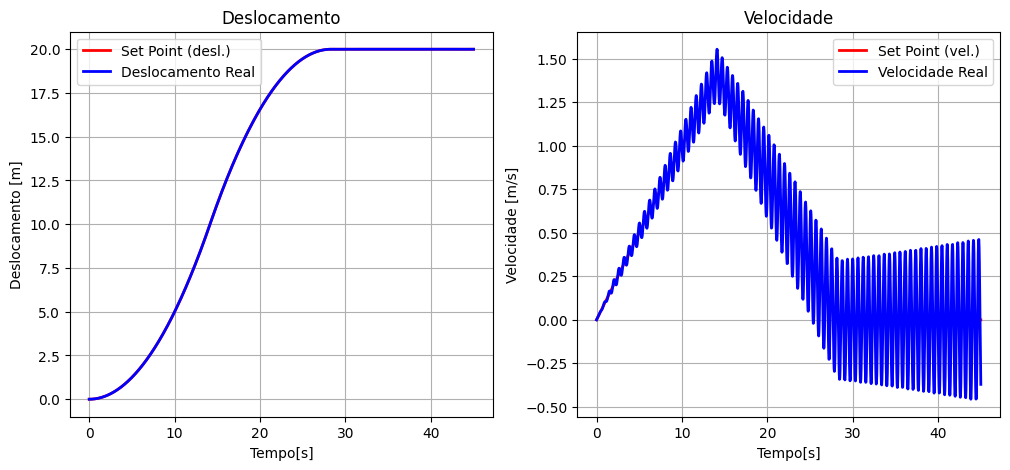

In [109]:
# Gráficos do deslocamento e da velocidade:

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(t_plot, Y, 'r', linewidth=2, label = 'Set Point (desl.)')
plt.plot(sol.t, sol.y[:][1],'b', linewidth=2, label='Deslocamento Real')
plt.xlabel('Tempo[s]')
plt.ylabel('Deslocamento [m]')
plt.legend()
plt.grid(True)
plt.title('Deslocamento')

plt.subplot(1,2,2)
plt.plot(t_plot, dY, 'r', linewidth=2, label = 'Set Point (vel.)')
plt.plot(sol.t, sol.y[:][3],'b', linewidth=2, label='Velocidade Real')
plt.xlabel('Tempo[s]')
plt.ylabel('Velocidade [m/s]')
plt.legend()
plt.grid(True)
plt.title('Velocidade')
